# Magasin example Notebook: DPGA Insights 

After running this notebook you will be able to:

* Use the Jupyterlab component of magasin to perform initial analysis of data. We will use [python](https://www.python.org/) as programming language.
* We will use this notebook to prepare the data pipelines (dagster) and dashboards (superset).


## Our example.
When we analyze some data, we start by just looking at the contents of the dataset and asking ourselves what are we going to ask to our data

In  this case, we are going play around with one simple API, the [Digital Public Goods Alliance (DPGA) API](https://github.com/DPGAlliance/publicgoods-api?tab=readme-ov-file). 


[Digital Public Goods (DPGs)](https://en.wikipedia.org/wiki/Digital_public_goods) are public goods in the form of software, data sets, AI models, standards or content that are generally free cultural works and have an intention to contribute to sustainable national and international digital development. Several international agencies, including [UNICEF](https://www.unicef.org) and [UNDP](https://undp.org), are exploring DPGs as a possible solution to address the issue of digital inclusion, particularly for children in emerging economies. 

The [DPGA API](https://api.digitalpublicgoods.net/) has 4 endpoints:

```json
{
	"dpgs": "https://api.digitalpublicgoods.net/dpgs",
	"dpg/{dpg}": "https://api.digitalpublicgoods.net/dpg/{dpg}/",
	"nominees": "https://api.digitalpublicgoods.net/nominees",
	"nominee/{nominee}": "https://api.digitalpublicgoods.net/nominee/{nominee}"
}
```
The first endpoint [dpgs](https://api.digitalpublicgoods.net/dpgs) and the third one [nominees](https://api.digitalpublicgoods.net/nominees), return a JSON array with a list of digital public goods and DPG nominee respectively.

Here you have the most relevant data

```json
[
{
        "id": "10002",
        "name": "Accessible Kazakhstan",
        "sectors": ["Health", "Nutrition"],
        "stage": "DPG",
        ...
        "aliases": [
            "Accessible Kazakhstan online map"
        ],
        "categories": [
            "Open Software"
        ],
        "locations": {
            "developmentCountries": [
                "Kazakhstan"
            ],
            "deploymentCountries": [
                "Kazakhstan"
            ]
        },
        "sdgs": {
            "sdg": [
                "SDG11: Sustainable Cities and Communities"
            ],
            "relevance": "..."
        },
        "openlicenses": [
            {
                "openLicense": "Apache-2.0",
                "openLicenseEvidenceURLs": "https://github.com/qlt2020/doskaz/blob/main/LICENSE"
            }
        ],
        ...
        "openStandards": [
            "W3C",
            " HTML",
            " CSS",
            " ECMAScript/ JavaScript",
            " REST",
            " JSON https://github.com/qlt2020/doskaz/blob/main/Coding%20Standards.pdf",
            "\r\nhttps://github.com/qlt2020/doskaz/tree/main/frontend",
            "\r\nhttps://github.com/qlt2020/doskaz/tree/main/backend "
        ],
        ...
    },
    {
      ...
    }
    ...
]
```
### So, what questions do we want to ask to the dataset?

Here we have some: 

- How many DPGs are there?
- Where are the DPGs being deployed
- How many deployments does each DGP have?
- What are the most common licenses?
- What is the distribution of DPGs by category? 

In [59]:
# Install packet dependencies. You can run commands by prepending "!" to the command.
!pip install pandas matplotlib seaborn requests

# List files in current folder
!ls -la

total 2936
drwxr-xr-x   6 jmerlostevar  staff      192 Jan 29 15:59 .
drwxr-xr-x   4 jmerlostevar  staff      128 Dec 27 17:14 ..
-rw-r--r--@  1 jmerlostevar  staff     6148 Dec 27 17:14 .DS_Store
drwxr-xr-x  27 jmerlostevar  staff      864 Jan 29 15:59 data
-rw-r--r--@  1 jmerlostevar  staff   152007 Jan 25 13:04 dpg-basic.ipynb
-rw-r--r--@  1 jmerlostevar  staff  1337983 Jan 29 16:45 dpg-insights.ipynb


In [60]:
# Some imports

import os
import json
import datetime

import requests
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# Download the data 

## Simple fast and dirty

In [61]:

print("Donwloading dpgs...")
dpgs_url = "https://api.digitalpublicgoods.net/dpgs"
dpgs_json = requests.get(dpgs_url).json()
os.makedirs("data", exist_ok=True)
with open(f"data/{datetime.date.today().strftime('%Y-%m-%d')}-dgps.json", "w") as f:
  json.dump(dpgs_json, f)
  print("Done")
print("Donwloading nominees...")
nominees_url = "https://api.digitalpublicgoods.net/nominees"
nominees_json = requests.get(nominees_url).json()
os.makedirs("data", exist_ok=True)
with open(f"data/{datetime.date.today().strftime('%Y-%m-%d')}-nominees.json", "w") as f:
  json.dump(nominees_json, f)
  print("Done")


Donwloading dpgs...
Done
Donwloading nominees...
Done


## DRY version (Don't repeat yourself)

Whereas the previous version is fast to implement, it is not structured and does not scale well. Imagine that you have 100 endpoints and you have to do the same... 

Our goal in working on this notebook is to prepare our future pipeline that will be written to be used Dagster, so we can already think about how we would write a more structured code so, to some extent, we just need copy paste.

In [62]:

API_BASE_URL="https://api.digitalpublicgoods.net" 

def get_today():
    '''
    returns todays date in the format YYYY-MM-DD (f.i. 2023-12-26)
    '''
    return datetime.date.today().strftime('%Y-%m-%d')

def get_list_from_dpga(stage="dpgs"):
  '''calls an API and returns the raw data as JSON'''

  url = f"{API_BASE_URL}/{stage}"
  return requests.get(url).json()
  
def save_json(json_data, stage="dpgs", folder_path='./data'):
  '''saves a json in the `folder_path`/YYYY-MM-DD-{stage}.json`
  as well as `latest-{stage}.json`
   
   json_data is the json dictionary to save
   stage is the stage of the DGP (dpgs, nominees)
   folder_path is the path to store the data. without '/'  
   '''
  os.makedirs(f"{folder_path}", exist_ok=True) 
  with open(f"{folder_path}/{get_today()}-{stage}.json", "w") as f:
    json.dump(json_data, f)
  with open(f"{folder_path}/latest-{stage}.json", "w") as f:
    json.dump(json_data, f)


def get_dpgs():
  '''
  gets the DPGs raw data from the DPGA API and stores it in the `data/` as a json 
  with the name YYYY-MM-DD-dpgs.json and lastest-dpgs.json
  '''
  save_json(get_list_from_dpga('dpgs'), stage='dpgs')

def get_nominees():
  '''
  gets the DPGs raw data from the DPGA API and stores it in the data/ as a json 
  with the name YYYY-MM-DD-dpgs.json 
  '''
  save_json(get_list_from_dpga('nominees'), stage='nominees', )


get_dpgs()
get_nominees()

## Load the data
First let's load the data and check out what we see

In [63]:
# Load the data as dataframes
dpgs_df = pd.read_json('./data/latest-dpgs.json')
nominees_df = pd.read_json('./data/latest-nominees.json')

# Note that we kept a copy of the 2023-12-27 version. 
# The data may change and some of the insights we comment may no longer be valid.
# If you want to load that data, just uncomment these lines below
#
# dpgs_df = pd.read_json('./data/2023-12-27-dpgs.json')
# nominees_df = pd.read_json('./data/2023-12-27-nominees.json')

def add_timestamp(df):
  """ 
  Adds a timestamp column. This will allow us to have time series in the future
  """
  df["timestamp"]=pd.Timestamp.now()
  return df

# Add a timestamp column
dpgs_df = add_timestamp(dpgs_df)
nominees_df = add_timestamp(nominees_df)


# Display some of the records to see what we got
dpgs_df.head(10)


,id,name,sectors,stage,privacy,organizations,platformIndependence,aliases,categories,description,...,openStandards,dataPrivacySecurity,userContent,protectionFromHarassment,bestPractices,deploymentCountriesDepartments,deploymentOrganisations,otherDeploymentOrganisations,awardsReceived,timestamp
0,10019,Care,[],DPG,[{'privacyCompliance': 'India's Personal Data ...,"[{'name': 'Care', 'website': 'https://ohc.netw...","{'isPlatformIndependent': 'No', 'openAlternati...",[Coronasafe Care],[Open Software],Care is a tool enabling TeleICU & Decentralise...,...,"[- OpenWeb Standard - HTML, CSS, ECMAScript,...",{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...","[Principles For Digital Development:, - Design...","[Government of Manipur, India\r\nGovernment o...",,,,2024-01-29 16:45:26.524593
1,10024,DIGIT,[],DPG,[{'privacyCompliance': 'Information Technology...,"[{'name': 'DIGIT', 'website': 'https://www.dig...","{'isPlatformIndependent': 'No', 'openAlternati...","[Digital Infrastructure for Governance, Impac...","[Open Software, ]","DIGIT is an open-source, configurable, extenda...",...,"[OpenAPI Specifications Transfer Protocol, HTT...",{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...","[1. Ecosystem-Driven, 2. Interoperability thro...",,,,,2024-01-29 16:45:26.524593
2,10025,DIVOC,[],DPG,[{'privacyCompliance': 'GDPR & HIPAA for perso...,"[{'name': 'DIVOC', 'website': 'https://divoc.e...","{'isPlatformIndependent': 'No', 'openAlternati...",[Digital Infrastructure for Vaccination Open C...,[Open Software],Open source digital platform for large scale d...,...,"[GS1, GTIN, EPCIS, ISO/IEC 12207 System archit...",{'collectsPII': 'PII data is NOT collected NOT...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...",[The link https://divoc.egov.org.in/tech-docs ...,,,,,2024-01-29 16:45:26.524593
3,10044,Hand-in-Hand Geospatial Platform,[],DPG,[{'privacyCompliance': 'PRIVACY POLICY FOR USE...,"[{'name': 'Hand-in-Hand Geospatial Platform', ...","{'isPlatformIndependent': 'No', 'openAlternati...",,[Open Data],The Hand-in-Hand Geospatial Platform is a supp...,...,"[HTTPS, HTML, CSS]",{'collectsPII': 'PII data is NOT collected NOT...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...","[Principles For Digital Development, \r\nHuman...",,,,,2024-01-29 16:45:26.524593
4,10051,iVerify,[],DPG,[{'privacyCompliance': 'Zambia: THE DATA PROTE...,"[{'name': 'iVerify', 'website': 'https://digit...","{'isPlatformIndependent': 'Yes', 'openAlternat...",[],[Open Software],AI-powered information platform to combat misi...,...,[1) Accessibility - WCAG 2.0/2.1 (Web Content ...,{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is collected an...,"{'facilitatesUserInteraction': 'No', 'harassme...","[Principles of Digital Development, \r\n\r\nS...",,[United Nations Development Programme],,,2024-01-29 16:45:26.524593
5,10057,Lexsitus,[],DPG,[{'privacyCompliance': 'General Data Protectio...,"[{'name': 'Lexsitus', 'website': 'https://cilr...","{'isPlatformIndependent': 'No', 'openAlternati...","[CILRAP-Lexsitus, The Lexsitus service]",[Open Content],Lexsitus is the most comprehensive online lega...,...,"[PDF, \r\nMP4, \r\nHTML]",{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is collected st...,"{'facilitatesUserInteraction': 'No', 'harassme...",[All Principles for Digital Development have b...,,,,,2024-01-29 16:45:26.524593
6,10067,Mojaloop,[],DPG,"[{'privacyCompliance': 'EEA Data Subject, GDPR...","[{'name': 'Mojaloop', 'website': 'https://moja...","{'isPlatformIndependent': 'No', 'openAlternati...",,[Open Software],Open source software for creating payment plat...,...,"[ISO200022, PCI, DSS ]",{'collectsPII': '

In [64]:
# Sme with nominees, display some of the records
nominees_df.head(10)


,id,name,sectors,stage,privacy,organizations,platformIndependence,categories,description,website,...,dataPrivacySecurity,userContent,protectionFromHarassment,bestPractices,aliases,deploymentOrganisations,deploymentCountriesDepartments,otherDeploymentOrganisations,awardsReceived,timestamp
0,10146,Antura and the Letters,[],nominee,[{'privacyCompliance': ' Data protection laws ...,"[{'name': 'Antura and the Letters', 'website':...","{'isPlatformIndependent': 'No', 'openAlternati...",[Open Content],Open source smartphone application that teach...,https://www.antura.org,...,{'collectsPII': 'PII data is NOT collected NOT...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...",[ ],,,,,,2024-01-29 16:45:26.525715
1,10522,ZIConnect AI Platform,[],nominee,[{'privacyCompliance': 'General Data Protectio...,"[{'name': 'ZIConnect AI Platform', 'website': ...","{'isPlatformIndependent': 'No', 'openAlternati...","[Open AI Model, Open Software]","With Unicef Innovation Fund and Giga Project, ...",https://unicef.jobzi.com,...,{'collectsPII': 'PII data is NOT collected NOT...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'Yes', 'harassm...",[Workflow for implementations and developments...,"[Jobzi ZIConnect AI Platform, Jobzi AI, Jobz...",[United Nations International Children],,,,2024-01-29 16:45:26.525715
2,10585,AletheiaFact.org,[],nominee,[{'privacyCompliance': 'LGPD: Brazil’s Data Pr...,"[{'name': 'AletheiaFact.org', 'website': 'http...","{'isPlatformIndependent': 'No', 'openAlternati...",[Open Software],AletheiaFact.org is a movement for the democra...,https://aletheiafact.org,...,{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is collected st...,"{'facilitatesUserInteraction': 'Yes', 'harassm...",[Software Development Life Cycle (SDLC): User ...,[Aletheia],,,,,2024-01-29 16:45:26.525715
3,10608,Open Health Information Mediator,[],nominee,[{'privacyCompliance': 'General Data Protectio...,"[{'name': 'Open Health Information Mediator', ...","{'isPlatformIndependent': 'No', 'openAlternati...",[Open Software],The Open Health Information Mediator (OpenHIM)...,http://openhim.org/,...,{'collectsPII': 'PII data is NOT collected NOT...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'Yes', 'harassm...",[The OpenHIM is a current reference technology...,[OpenHIM],,"[Rwanda, South Africa]",[PEPFAR / DATIM],[Cited at the OpenHIE Community Meeting in Mal...,2024-01-29 16:45:26.525715
4,10718,OpenHIE,[],nominee,[{'privacyCompliance': 'Although what is discl...,"[{'name': 'OpenHIE', 'website': 'https://ohie....","{'isPlatformIndependent': 'No', 'openAlternati...",[Open Content],OpenHIE is a global mission-driven community o...,https://ohie.org/,...,{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is collected st...,"{'facilitatesUserInteraction': 'Yes', 'harassm...",[Principles of Digital Development - https://d...,[OHIE],"[World Health Organization (WHO), World Bank]",[Country representatives from each of the coun...,[OpenHIE partner organizations which can be fo...,[Digital Square Global Goods],2024-01-29 16:45:26.525715
5,10782,Doptor Open Data,[],nominee,[{'privacyCompliance': 'Doptor Open Data compl...,"[{'name': 'Doptor Open Data', 'website': ' htt...","{'isPlatformIndependent': 'No', 'openAlternati...",[Open Data],Doptor Open Data aims to bring all the eServic...,http://dpgdata.doptor.gov.bd/,...,{'collectsPII': 'PII data is collected and sto...,{'contentManagement': 'Content is NOT collecte...,"{'facilitatesUserInteraction': 'No', 'harassme...","[FAIR Data Principles, OpenAPI Specification,...",[Doptor],,[All Ministries of Bangladesh government uses ...,,,2024-01-29 16:45:26.525715
6,10798,Jellow AAC Communicator,[],nominee,[{'privacyCompliance': 'REGULATION (EU) 2016/6...,"[{'name': 'Jellow AAC Communicator', 'website'...","{'isPlatformIndependent': 'Yes', 'openAlte

In [65]:
dpgs_df.locations[0]

{'developmentCountries': ['India'], 'deploymentCountries': ['India']}

## First insights

Looking at the output above and at the original json https://api.digitalpublicgoods.net/dpgs/, we can highlight:

* The lists returned by the API are small, the largest one has less than 200 items, so we can perfectly play with the data in memory, we don't have to worry too much about that.
* `sectors` column seems to be empty, so we won't be able to get stats from sectors.
* There are some columns that are objects, such as `locations` that has two attributes inside `developmentCountries` and `deploymentCountries`. We can use [`pandas.json_normalize`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html) to expand the original column and extend it.
* Both `dpgs_df` and `nomminees_df` dataframes have the same data_structure, the only difference is the value of the `stage`.



In [66]:

def normalize_columns(df, column_list):
  ''' Normalizes the columns of a particular dataframe. Each column in `column_list` is expected to have a json 
  object. This function will extract each attribute in those objects as a new column.
  '''
  for column in column_list:
    df = pd.merge(df, pd.json_normalize(df[column]), left_index=True, right_index=True)
  return df

# We will be working only with the dpgs, ignoring the nominees
df = normalize_columns(dpgs_df, ['platformIndependence', 'locations', 'sdgs', 'dataPrivacySecurity',\
                                  'NonPII', 'protectionFromHarassment', 'userContent' ]
                                  )
df.head()



,id,name,sectors,stage,privacy,organizations,platformIndependence,aliases,categories,description,...,collectsPII,typesOfPIIDataCollected,dataPrivacySecurity_y,collectsNonPII,nonPIIAccessMechanism,facilitatesUserInteraction,harassmentPolicy,contentManagement,contentTypes,contentManagementPolicy
0,10019,Care,[],DPG,[{'privacyCompliance': 'India's Personal Data ...,"[{'name': 'Care', 'website': 'https://ohc.netw...","{'isPlatformIndependent': 'No', 'openAlternati...",[Coronasafe Care],[Open Software],Care is a tool enabling TeleICU & Decentralise...,...,PII data is collected and stored but NOT distr...,"[Full name, Home address, Email address, Passp...",The software has implemented many best practi...,Yes,We have CSV exports and Public API's,No,,Content is NOT collected NOT stored and NOT di...,[],
1,10024,DIGIT,[],DPG,[{'privacyCompliance': 'Information Technology...,"[{'name': 'DIGIT', 'website': 'https://www.dig...","{'isPlatformIndependent': 'No', 'openAlternati...","[Digital Infrastructure for Governance, Impac...","[Open Software, ]","DIGIT is an open-source, configurable, extenda...",...,PII data is collected and stored and distributed.,[We collect information/data (“data”) to impro...,We use this data to serve you with the best ci...,Yes,DIGIT supports the creation of reports and das...,No,,Content is NOT collected NOT stored and NOT di...,[],
2,10025,DIVOC,[],DPG,[{'privacyCompliance': 'GDPR & HIPAA for perso...,"[{'name': 'DIVOC', 'website': 'https://divoc.e...","{'isPlatformIndependent': 'No', 'openAlternati...",[Digital Infrastructure for Vaccination Open C...,[Open Software],Open source digital platform for large scale d...,...,PII data is NOT collected NOT stored and NOT d...,[],,Yes,"CSV, JSON, SQL, REST API. \r\n\r\nAdditionally...",No,,Content is NOT collected NOT stored and NOT di...,[],
3,10044,Hand-in-Hand Geospatial Platform,[],DPG,[{'privacyCompliance': 'PRIVACY POLICY FOR USE...,"[{'name': 'Hand-in-Hand Geospatial Platform', ...","{'isPlatformIndependent': 'No', 'openAlternati...",,[Open Data],The Hand-in-Hand Geospatial Platform is a supp...,...,PII data is NOT collected NOT stored and NOT d...,[],,Yes,"Data is available to download in CSV, XML, JSO...",No,,Content is NOT collected NOT stored and NOT di...,[],
4,10051,iVerify,[],DPG,[{'privacyCompliance': 'Zambia: THE DATA PROTE...,"[{'name': 'iVerify', 'website': 'https://digit...","{'isPlatformIndependent': 'Yes', 'openAlternat...",[],[Open Software],AI-powered information platform to combat misi...,...,PII data is collected and stored but NOT distr...,"[iVerify collects PII data on the volunteer, -...",iVerify has undertaken : Media Information La...,Yes,There is a REST API for internal use to export...,No,,Content is collected and stored but NOT distri...,[News articles and stories],All content presented publicly has a strict mo...


In [67]:
# List all the columns that the DataFrame has.
df.columns.values

array(['id', 'name', 'sectors', 'stage', 'privacy', 'organizations',
       'platformIndependence', 'aliases', 'categories', 'description',
       'website', 'repositories', 'locations', 'sdgs', 'openlicenses',
       'clearOwnership', 'documentation', 'NonPII', 'openStandards',
       'dataPrivacySecurity_x', 'userContent', 'protectionFromHarassment',
       'bestPractices', 'deploymentCountriesDepartments',
       'deploymentOrganisations', 'otherDeploymentOrganisations',
       'awardsReceived', 'timestamp', 'isPlatformIndependent',
       'openAlternatives', 'developmentCountries', 'deploymentCountries',
       'sdg', 'relevance', 'collectsPII', 'typesOfPIIDataCollected',
       'dataPrivacySecurity_y', 'collectsNonPII', 'nonPIIAccessMechanism',
       'facilitatesUserInteraction', 'harassmentPolicy',
       'contentManagement', 'contentTypes', 'contentManagementPolicy'],
      dtype=object)

# Create easier to analyze tables


As you can see, there are some columns that contain arrays. 
For example: 


| name     | deploymentCountries |   |   |   |
|----------|---------------------|---|---|---|
| primero  | [Kenya, Panama]     |   |   |   |
| rapidpro | [India, Colombia]   |   |   |   |


If we want to ask questions such as how many deployment countries does primero have, it is better to have one row for each country. As that way we can use simple pandas filters to count the number of fields. 

In order to expand the arrays to have one row per item in the array we will be calling the [pd.DataFrame.explode function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html). 

In the example abovew, the resulting table will be:

| name     | deploymentCountries | ... |
|----------|---------------------|-----|
| primero  | Kenya               | ... |
| primero  | Panama              | ... |
| rapidpro | India               | ... |
| rapidpro | Colombia            | ... |

This table also allows us to answer how many deployments we have per country. To do that we just need to count the number of times Kenya, Panama, India, Colombia, etc. appear. 

We will create several of these tables and store each of them in a separated file in a [columnar format](https://en.wikipedia.org/wiki/RCFile) called [parquet](https://github.com/apache/parquet-format). [Parquet has many advantages](https://coralogix.com/blog/parquet-file-format/). Though it heavily depends on the task to perform, as a general approach in magasin we prefer to store our datasets in parquet. 



In [70]:
def explode_columns(df, columns_to_explode=[]): 
    '''
    Explodes the columns that are arrays in the dataframe. It creates one row
    of for each item repeating the rest of the information on the column.


    df is the dataframe to explode
    columns_to_explode is an array of columns to explode
    filter=[]
    '''
    #df2 = df.copy()  
    df2 = df
    for col in columns_to_explode:
      df2 = df2.explode(col)
    return df2[['id','name', 'website', 'stage','timestamp'] + columns_to_explode]

def handle_inconsistent_types(df, column_name):
    """
    Handle inconsistent types in a DataFrame column.

    This function checks if the values in a specified column are lists.
    If a value is not a list, it is replaced with an empty list.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - column_name (str): The name of the column to handle.

    Returns:
    pandas.DataFrame: A DataFrame with consistent types in the specified column.

    Example:
    >>> df = pd.DataFrame({'column1': [1, 2, 3], 'column2': ['A', 'B', 'C'], 'aliases': ['', [], ['X', 'Y']]})
    >>> handle_inconsistent_types(df, 'aliases')
    """
    df[column_name] = df[column_name].apply(lambda x: x if isinstance(x, list) else [])
    return df


def save_df_to_parquet(df, name, folder_path='./data'):
  '''
  Saves the pandas df in the `folder_path` as `YYYY-MM-DD-{name}.parquet`
  Also saves `latest-{name}.parquet` with the same information.
   
   json_data is the json dictionary to save
   name is the type of resource ()
   folder_path is the path to store the data. without '/'  

   Returns nothing
   '''
  os.makedirs(folder_path, exist_ok=True) 
  df.to_parquet(f"{folder_path}/{get_today()}-{name}.parquet")
  df.to_parquet(f"{folder_path}/latest-{name}.parquet")



# Explode columns and save them to files
deployment_countries_df = explode_columns(df,['deploymentCountries'])
save_df_to_parquet(deployment_countries_df,'deployment-countries')

development_countries_df = explode_columns(df, ['developmentCountries'])
save_df_to_parquet(development_countries_df, 'development-countries')

categories_df = explode_columns(df, ['categories'])
save_df_to_parquet(categories_df, 'categories')

sdgs_df = explode_columns(df, ['sdg'])

# There is an issue with the ',' character. We fix it.
sdgs_df['sdg'] = sdgs_df['sdg'].str.replace('¸', ',')
sdgs_df['sdg'] = sdgs_df['sdg'].str.replace('&#184;', ',')

save_df_to_parquet(sdgs_df, 'sdgs')



# Special case of array of objects

`openLicenses`` column is an array of objects `[ {openLicense, openLicenseEvidence}, ... ]`. Example:

```json  
        "openlicenses": [
            {
                "openLicense": "AGPL-3.0",
                "openLicenseEvidenceURLs": "https://github.com/.../whatever1"
            },
            {
                "openLicense": "BSD-2-Clause",
                "openLicenseEvidenceURLs": "https://github.com/.../whatever"
            }
        ],
```   

If we want to count the number of times a license is used, first need to explode the array, that is create one row per object, and then we need to extract the columns using `pd.normalize()`.

However, we have an issue. We need to re-index the exploded DataFrame because when the array has more than one item,
when it is exploded, it keeps the same index for both.
Example:    

In [ ]:

dfa = pd.DataFrame({'data': [[{"a": 1, "b": 2}, {"c": 3}], [{"d": 4}], []]})
df_exploded = dfa.explode('data')
df_normalized = normalize_columns(df_exploded,['data'])
print('dfa (3 rows)', dfa)
print('df_exploded (index 2 repeated)', df_exploded)
print('normalized (index are not repeated)', df_normalized)
print('-----')

df_exploded = df_exploded.reset_index(drop=True)
df_normalized = normalize_columns(df_exploded,['data'])
print('df_exploded (indexes no repeated)', df_exploded)
print('normalized (index are not repeated)', df_normalized)
print('-----')


dfa (3 rows)                            data
0  [{'a': 1, 'b': 2}, {'c': 3}]
1                    [{'d': 4}]
2                            []
df_exploded (index 2 repeated)                data
0  {'a': 1, 'b': 2}
0          {'c': 3}
1          {'d': 4}
2               NaN
normalized (index are not repeated)                data    a    b    c    d
0  {'a': 1, 'b': 2}  1.0  2.0  NaN  NaN
0          {'c': 3}  1.0  2.0  NaN  NaN
1          {'d': 4}  NaN  NaN  3.0  NaN
2               NaN  NaN  NaN  NaN  4.0
-----
df_exploded (indexes no repeated)                data
0  {'a': 1, 'b': 2}
1          {'c': 3}
2          {'d': 4}
3               NaN
normalized (index are not repeated)                data    a    b    c    d
0  {'a': 1, 'b': 2}  1.0  2.0  NaN  NaN
1          {'c': 3}  NaN  NaN  3.0  NaN
2          {'d': 4}  NaN  NaN  NaN  4.0
3               NaN  NaN  NaN  NaN  NaN
-----


In [ ]:
# So now we reindex after exploding
open_licenses_df = normalize_columns(explode_columns(df, ['openlicenses']).reset_index(drop=True),['openlicenses'])
save_df_to_parquet(open_licenses_df, 'open-licenses')


clear_ownership_df = normalize_columns(explode_columns(df, ['clearOwnership']).reset_index(drop=True),['clearOwnership'])
save_df_to_parquet(clear_ownership_df, 'clear-ownership')




In [ ]:

deployment_countries_df.head()


,id,name,website,stage,timestamp,deploymentCountries
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,India
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,India
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,India
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,Sri Lanka
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,Afghanistan


In [ ]:
development_countries_df.head()


,id,name,website,stage,timestamp,developmentCountries
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,India
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,India
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,India
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,Afghanistan
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,Angola


In [ ]:
categories_df.head()


,id,name,website,stage,timestamp,categories
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,Open Software
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,Open Software
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,Open Software
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,Open Data


In [ ]:
open_licenses_df.head()

,id,name,website,stage,timestamp,openlicenses,openLicense,openLicenseEvidenceURLs
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/coronasafe/care/blob/master...
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/egovernments/DIGIT-OSS/blob...
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/egovernments/DIVOC/blob/mai...
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'CC-BY-NC-SA-3.0', 'openLicens...",CC-BY-NC-SA-3.0,https://www.fao.org/3/ca7570en/ca7570en.pdf
4,10051,iVerify,https://digital.undp.org/iVerify-Zambia,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'AGPL-3.0', 'openLicenseEviden...",AGPL-3.0,https://github.com/undp/iVerify-Apps/blob/main...


In [ ]:
clear_ownership_df.head()

,id,name,website,stage,timestamp,clearOwnership,clearOwnershipName,clearOwnershipURL
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,"{'clearOwnershipName': 'Coronasafe Network', '...",Coronasafe Network,https://coronasafe.network/\r\n\r\n
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,{'clearOwnershipName': 'eGovernments Foundatio...,eGovernments Foundation,https://github.com/egovernments/DIGIT-OSS/blob...
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,{'clearOwnershipName': 'eGovernments Foundatio...,eGovernments Foundation,https://github.com/egovernments/DIVOC/blob/mai...
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,"{'clearOwnershipName': 'FAO', 'clearOwnershipU...",FAO,https://www.fao.org/hih-geospatial-platform/en/
4,10051,iVerify,https://digital.undp.org/iVerify-Zambia,DPG,2024-01-29 15:59:56.048668,{'clearOwnershipName': 'United Nations Develop...,United Nations Development Programme,https://github.com/undp/iVerify-Apps#readme


In [ ]:

sdgs_df.head()


,id,name,website,stage,timestamp,sdg
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,SDG3: Good Health and Well-Being
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,"SDG9: Industry, Innovation and Infrastructure"
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,SDG11: Sustainable Cities and Communities
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,SDG17: Partnerships for the Goals
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,SDG3: Good Health and Well-Being


------
------

# Analyzing the data

Now that we have the data separated in columns that are easier to analyze. Well do some analysis.


## In which countries are the DPGs being deployed?

In [ ]:


#ignoring case
deployments_per_country = deployment_countries_df.groupby(deployment_countries_df['deploymentCountries'].str.lower()).size().sort_values(ascending=False).reset_index(name="numberOfDPGs")
  
number_of_dpgs = df.shape[0]
total_deployments = deployment_countries_df.shape[0]
number_of_deployment_countries = deployments_per_country.shape[0]


print('---------------------------------------------------------')
print(f'Number of DPGs                  : {number_of_dpgs}')
print(f'Total deployments                : {total_deployments}')
print(f'Average # of deployments/DPG     : {total_deployments / number_of_dpgs }')
print(f'Num. of countries with DPGs      : {number_of_deployment_countries}')
print(f'Average # of deployments/country : { total_deployments / number_of_deployment_countries }')
print('---------------------------------------------------------')
print('Top 20 countries in # of deployments')
print('---------------------------------------------------------')
#deployments_per_country
deployments_per_country[:20]


---------------------------------------------------------
Number of DPGs                  : 142
Total deployments                : 2845
Average # of deployments/DPG     : 20.035211267605632
Num. of countries with DPGs      : 198
Average # of deployments/country : 14.368686868686869
---------------------------------------------------------
Top 20 countries in # of deployments
---------------------------------------------------------


,deploymentCountries,numberOfDPGs
0,india,52
1,united states of america,48
2,bangladesh,34
3,uganda,33
4,kenya,32
5,tanzania,31
6,brazil,29
7,germany,28
8,nepal,27
9,nigeria,27


Now, let's display this data in a graph

Text(0, 0.5, 'Country of development')

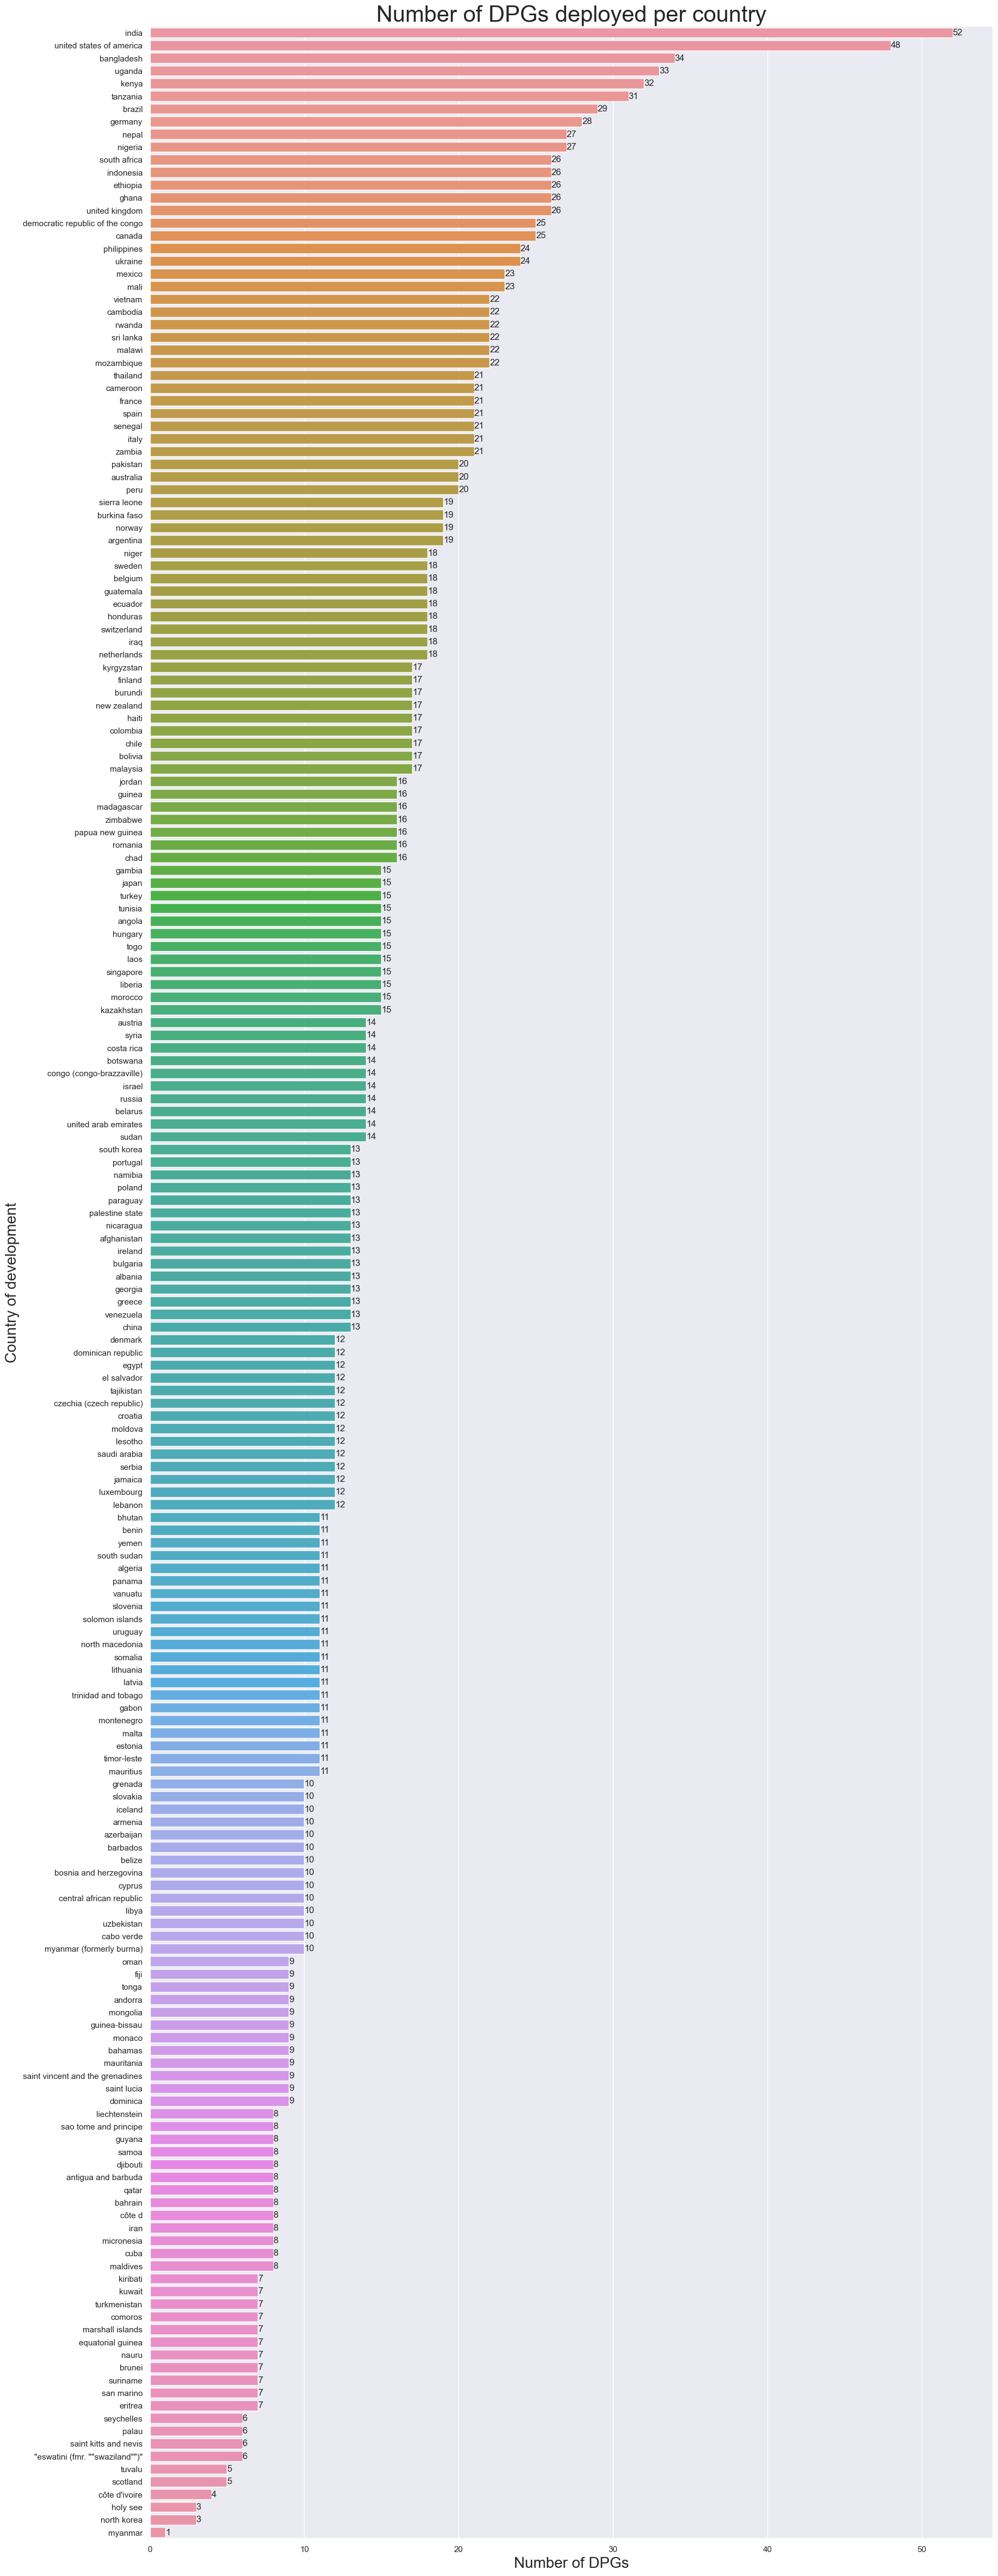

In [ ]:
#Display deployment countries and numberOfDPGs

sns.set(rc={"figure.figsize":(20, 60)}) #width=3, #height=
ax = sns.barplot(y="deploymentCountries", x="numberOfDPGs", data=deployments_per_country )
_ = ax.bar_label(ax.containers[0])

plt.title("Number of DPGs deployed per country", size=30)
plt.xlabel("Number of DPGs", size=20)
plt.ylabel("Country of development", size=20)



## Hummm, we have 226 countries...

The first thing we can notice after analyzing this data (Dec 2023) is that there are **226 countries** which is weird as the United Nations have only recognized 195 countries. 

To see what's happening we're going to list all the countries we got and try to evaluate what's going on.

In [ ]:
for country in sorted(deployment_countries_df.deploymentCountries.unique()):
    print(f"[{country}]") # We enclose the countries in [] as there may be spaces.

["Eswatini (fmr. ""Swaziland"")"]
[Afghanistan]
[Albania]
[Algeria]
[Andorra]
[Angola]
[Antigua and Barbuda]
[Argentina]
[Armenia]
[Australia]
[Austria]
[Azerbaijan]
[Bahamas]
[Bahrain]
[Bangladesh]
[Barbados]
[Belarus]
[Belgium]
[Belize]
[Benin]
[Bhutan]
[Bolivia]
[Bosnia and Herzegovina]
[Botswana]
[Brazil]
[Brunei]
[Bulgaria]
[Burkina Faso]
[Burundi]
[Cabo Verde]
[Cambodia]
[Cameroon]
[Canada]
[Central African Republic]
[Chad]
[Chile]
[China]
[Colombia]
[Comoros]
[Congo (Congo-Brazzaville)]
[Costa Rica]
[Croatia]
[Cuba]
[Cyprus]
[Czechia (Czech Republic)]
[Côte d]
[Côte d'Ivoire]
[Democratic Republic of the Congo]
[Denmark]
[Djibouti]
[Dominica]
[Dominican Republic]
[Ecuador]
[Egypt]
[El Salvador]
[Equatorial Guinea]
[Eritrea]
[Estonia]
[Ethiopia]
[Fiji]
[Finland]
[France]
[Gabon]
[Gambia]
[Georgia]
[Germany]
[Ghana]
[Greece]
[Grenada]
[Guatemala]
[Guinea]
[Guinea-Bissau]
[Guyana]
[Haiti]
[Holy See]
[Honduras]
[Hungary]
[Iceland]
[India]
[Indonesia]
[Iran]
[Iraq]
[Ireland]
[Israel]



By analyzing the list of countries we can see something that, unfortunately, it is a very common issue, the quality of the captured data is not as good as we would like. 

We can see: 

* There are some misspelling that generates duplicates (for instance, `Eswatini (fmr. 'Swaziland')` vs `"Eswatini (fmr. ""Swaziland"")"`, `"Côte d"` vs `"Côte d'Ivoire"`, `Myanmar` vs `Myanmar (formerly Burma` ...)

* Also, there are territories that are considered countries (such as `Gibraltar` or 'Hong Kong')

* There are rows with an empty country.

----

### Data-informed organization should focus on creating quality data

If we get data with issues we will have to spend data scientists time cleaning the data and fixing issues and our insights may be misleading. 

It is also truth that these kind of issues are, in many times, discovered through analyzing the data itself, so iterative processes on improving the data should be established too.
----

Ok, let's move on.

## Which countries are developing DPGs?

Something taht we observed is that the large majority of the Top 20 countries that are implementing DPGs are Low and Middle income Countries (LMICs). Is it also true for where these DPGs are being developed? Is the human resources talent in the same countries in which these are being deployed? 

Let's see...

In [ ]:
developments_per_country = development_countries_df.groupby('developmentCountries').size().sort_values(ascending=False).reset_index(name="numberOfDPGs")

# lowercase
#developments_per_country = development_countries_df.groupby(development_countries_df['developmentCountries'].str.lower()).size().sort_values(ascending=False).reset_index(name="numberOfDPGs")
number_of_development_countries = developments_per_country.size

print('---------------------------------------------------------')
print(f'Num. of countries developing DPGs      : {number_of_development_countries}')
print('---------------------------------------------------------')
print('Top 20 countries in # of development')
print('---------------------------------------------------------')
developments_per_country[:20]

---------------------------------------------------------
Num. of countries developing DPGs      : 282
---------------------------------------------------------
Top 20 countries in # of development
---------------------------------------------------------


,developmentCountries,numberOfDPGs
0,United States of America,54
1,India,36
2,United Kingdom,24
3,Canada,16
4,Germany,16
5,Belgium,14
6,Kenya,14
7,France,13
8,Spain,13
9,Italy,12


Text(0, 0.5, 'Country of development')

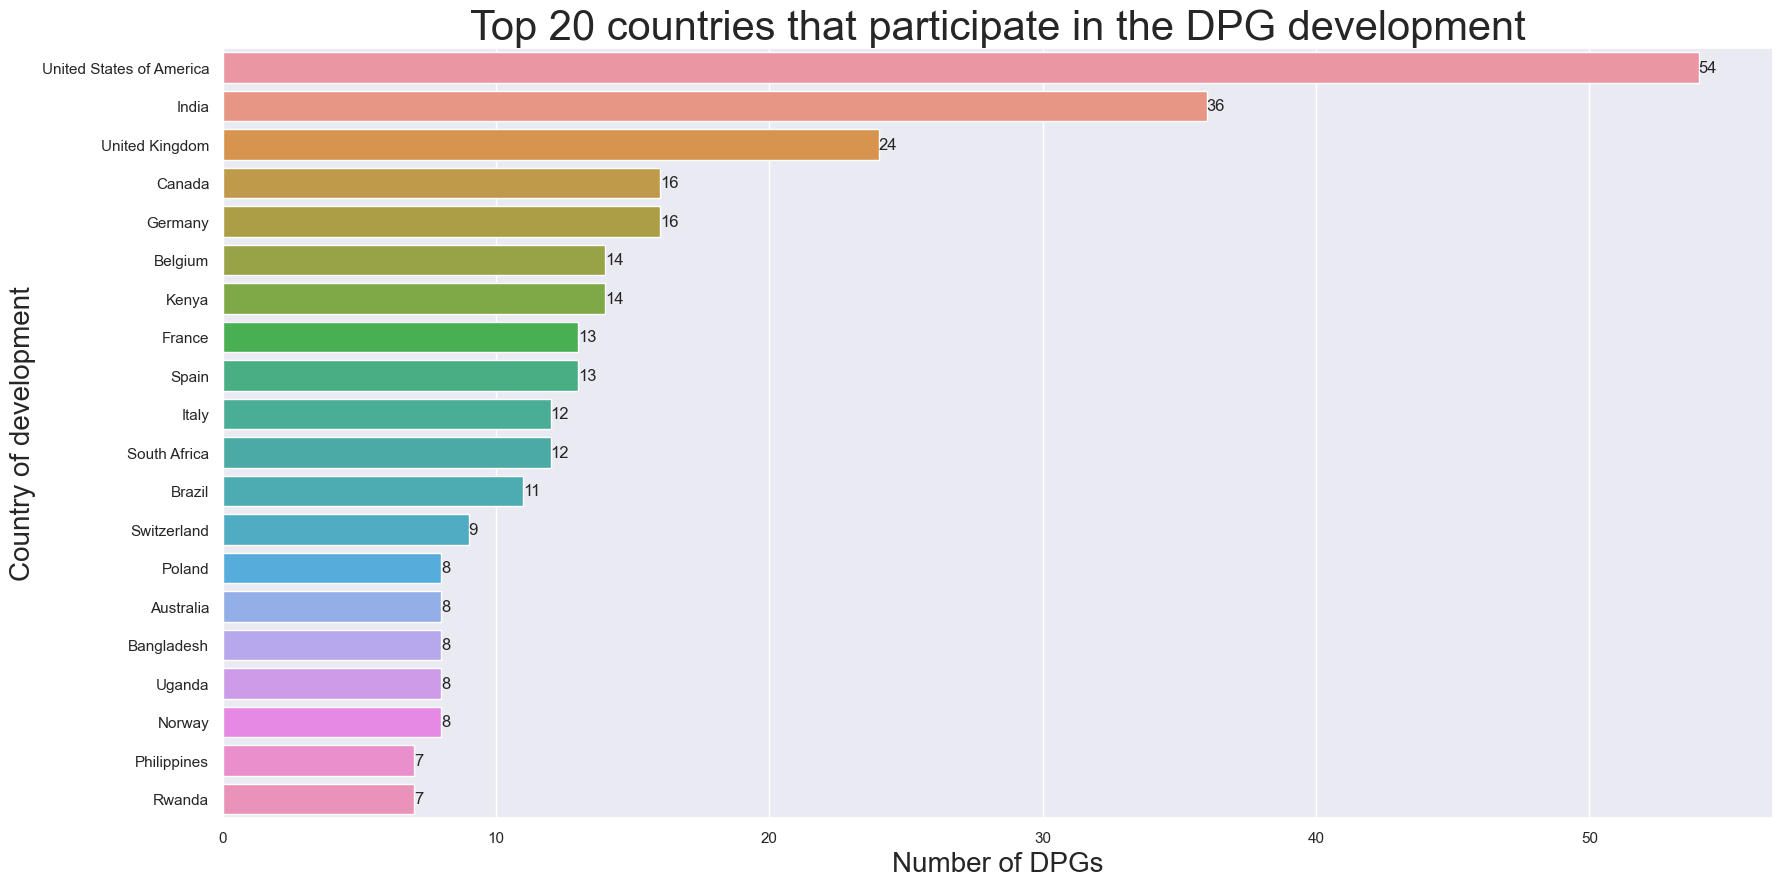

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=
ax = sns.barplot(y="developmentCountries", x="numberOfDPGs", data=developments_per_country[:20] )
_ = ax.bar_label(ax.containers[0])

plt.title("Top 20 countries that participate in the DPG development", size=30)
plt.xlabel("Number of DPGs", size=20)
plt.ylabel("Country of development", size=20)



## Number of deployments per DPG

In [ ]:
# Number of deployments per dpg
deployments_per_dpg = deployment_countries_df.groupby('name').size().sort_values(ascending=False).reset_index(name="numberOfDeployments")

# 
deployments_per_dpg['relative']= deployments_per_dpg['numberOfDeployments'] / total_deployments
top_20_dpgs_deployments = deployments_per_dpg['numberOfDeployments'][:20].sum()
percentage_of_top_20 = (top_20_dpgs_deployments * 100)/total_deployments
print("-----")
print(f"Total_deployments: {total_deployments}")
print(f"Top 20 DPGs number of deployments: {top_20_dpgs_deployments}")
print(f"Top 20 DPGs percentage of deployments: {percentage_of_top_20}")
print("----")

deployments_per_dpg[:20]


-----
Total_deployments: 2845
Top 20 DPGs number of deployments: 2161
Top 20 DPGs percentage of deployments: 75.95782073813709
----


,name,numberOfDeployments,relative
0,ODK,193,0.067838
1,OpenStreetMap,193,0.067838
2,KoboToolbox,190,0.066784
3,Fedora Linux,187,0.065729
4,MET Norway Weather API,184,0.064675
5,Kolibri,181,0.063620
6,TrueNAS,163,0.057293
7,LibreOffice,119,0.041828
8,Moodle LMS,99,0.034798
9,Mautic,85,0.029877


------

## Exercises set 1. Deployment and development countries

The best way to learn is by doing. Here we propose some exercises

1. How can you clean the countries so that it you get only the UN recognized countries? Where can you get an official/standard list of countries? 

2. What other questions can you extract from these tables? What about correlations? What about relative numbers? Would be interesting to show percentiles? Do you think you could get interesting insights if you add some more data for each country such as the continent, population, gross domestic product (GDP)? 

### [Share your answers Online - Join the dicussion](https://github.com/unicef/magasin/discussions/11)

-----

Let's continue with our analysis.

## What are the most common OSI licenses?

In [ ]:
open_licenses_df


,id,name,website,stage,timestamp,openlicenses,openLicense,openLicenseEvidenceURLs
0,10019,Care,https://ohc.network/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/coronasafe/care/blob/master...
1,10024,DIGIT,https://www.digit.org/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/egovernments/DIGIT-OSS/blob...
2,10025,DIVOC,https://divoc.egov.org.in/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MIT', 'openLicenseEvidenceURL...",MIT,https://github.com/egovernments/DIVOC/blob/mai...
3,10044,Hand-in-Hand Geospatial Platform,https://www.fao.org/hih-geospatial-platform/en/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'CC-BY-NC-SA-3.0', 'openLicens...",CC-BY-NC-SA-3.0,https://www.fao.org/3/ca7570en/ca7570en.pdf
4,10051,iVerify,https://digital.undp.org/iVerify-Zambia,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'AGPL-3.0', 'openLicenseEviden...",AGPL-3.0,https://github.com/undp/iVerify-Apps/blob/main...
...,...,...,...,...,...,...,...,...
249,11205,Mautic,https://www.mautic.org,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'GPL-3.0', 'openLicenseEvidenc...",GPL-3.0,https://github.com/mautic/mautic?tab=License-1...
250,11213,Open Health Stack,https://developers.google.com/open-health-stack,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'Apache-2.0', 'openLicenseEvid...",Apache-2.0,https://github.com/google/android-fhir/blob/ma...
251,11222,Harmony,https://www.zenysis.com/solution/platform/,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'AGPL-3.0', 'openLicenseEviden...",AGPL-3.0,https://github.com/Zenysis/Harmony/blob/main/L...
252,11231,OpenMRS,https://openmrs.org,DPG,2024-01-29 15:59:56.048668,"{'openLicense': 'MPL-2.0', 'openLicenseEvidenc...",MPL-2.0,https://github.com/openmrs/openmrs-core/blob/m...


In [ ]:

licenses_count_df = open_licenses_df.groupby('openLicense').size().sort_values(ascending=False).reset_index(name='numberOfDPGs')

licenses_count_df.head(20)

,openLicense,numberOfDPGs
0,MIT,27
1,AGPL-3.0,26
2,GPL-3.0,24
3,Apache-2.0,21
4,MPL-2.0,12
5,CC-BY-4.0,11
6,LGPL-3.0,8
7,BSD-3-Clause,7
8,GPL-2.0,7
9,CC0-1.0,6


Text(0, 0.5, 'License')

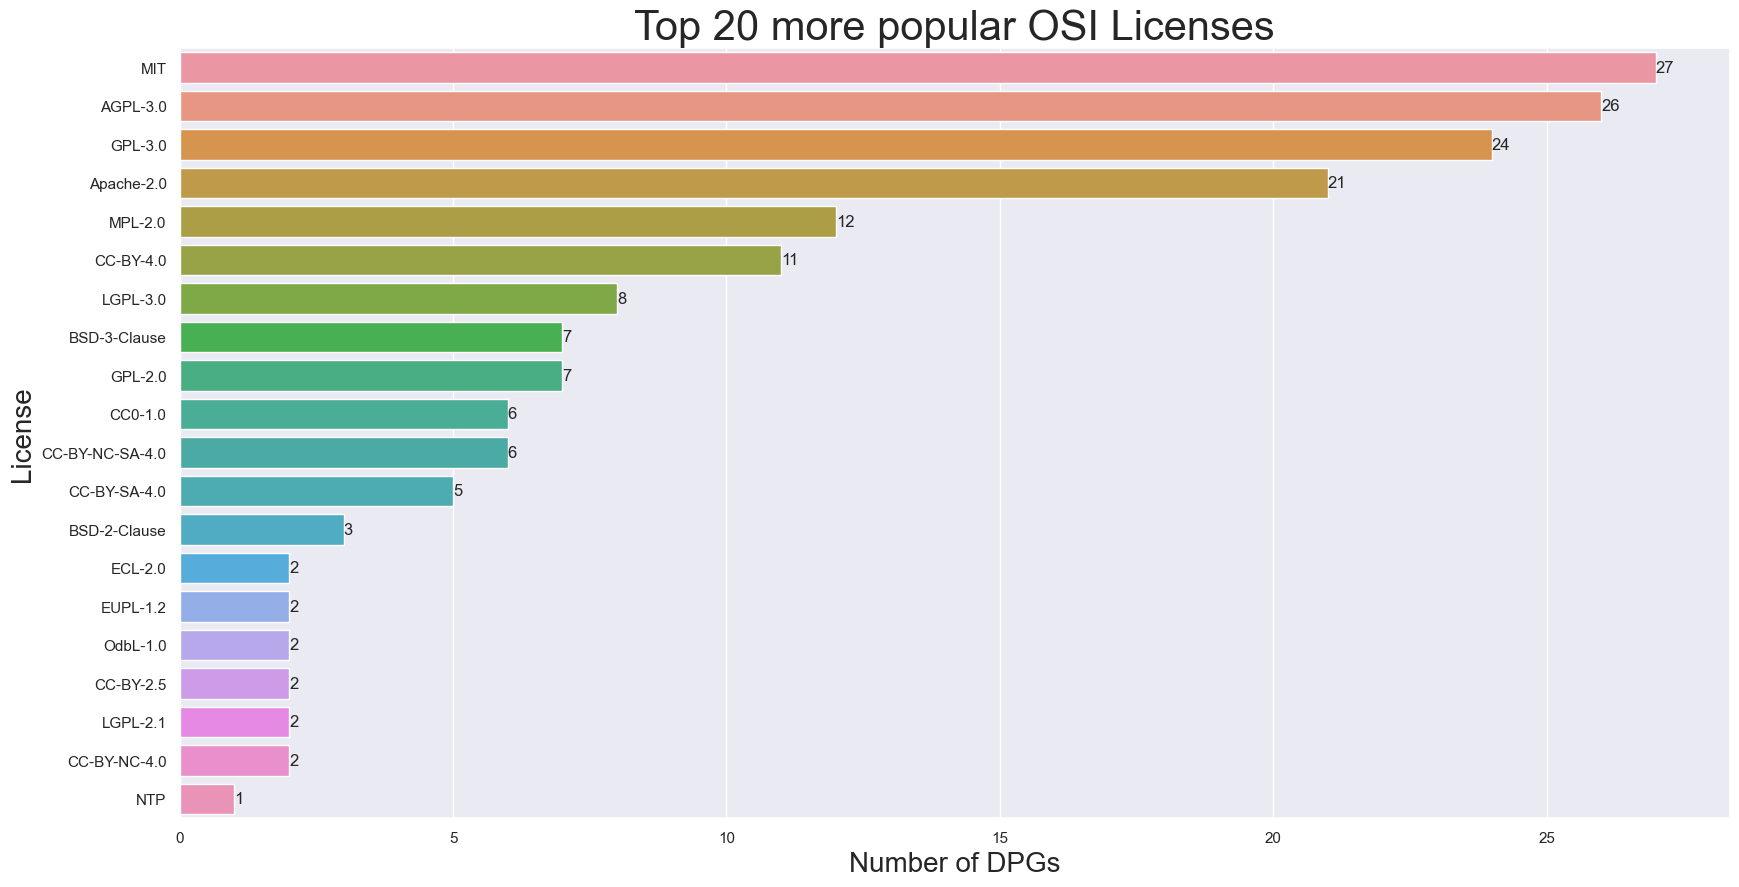

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=
ax = sns.barplot(y="openLicense", x="numberOfDPGs", data=licenses_count_df[:20] )
_ = ax.bar_label(ax.containers[0])

plt.title("Top 20 more popular OSI Licenses", size=30)
plt.xlabel("Number of DPGs", size=20)
plt.ylabel("License", size=20)



# What SDGs are having more attention within the DPG community?

In [ ]:
 
sdgs_count_df = sdgs_df.groupby('sdg').size().sort_values(ascending=False).reset_index(name="numberOfDPGs")
sdgs_count_df

,sdg,numberOfDPGs
0,SDG3: Good Health and Well-Being,68
1,SDG10: Reduced Inequalities,37
2,SDG4: Quality Education,37
3,SDG8: Decent Work and Economic Growth,28
4,"SDG16: Peace, Justice and Strong Institutions",26
5,SDG17: Partnerships for the Goals,26
6,"SDG9: Industry, Innovation and Infrastructure",25
7,SDG1: End Poverty in all its forms everywhere,24
8,SDG5: Gender Equity,22
9,SDG11: Sustainable Cities and Communities,20


Text(0, 0.5, 'Sustainable Development Goal (SDG)')

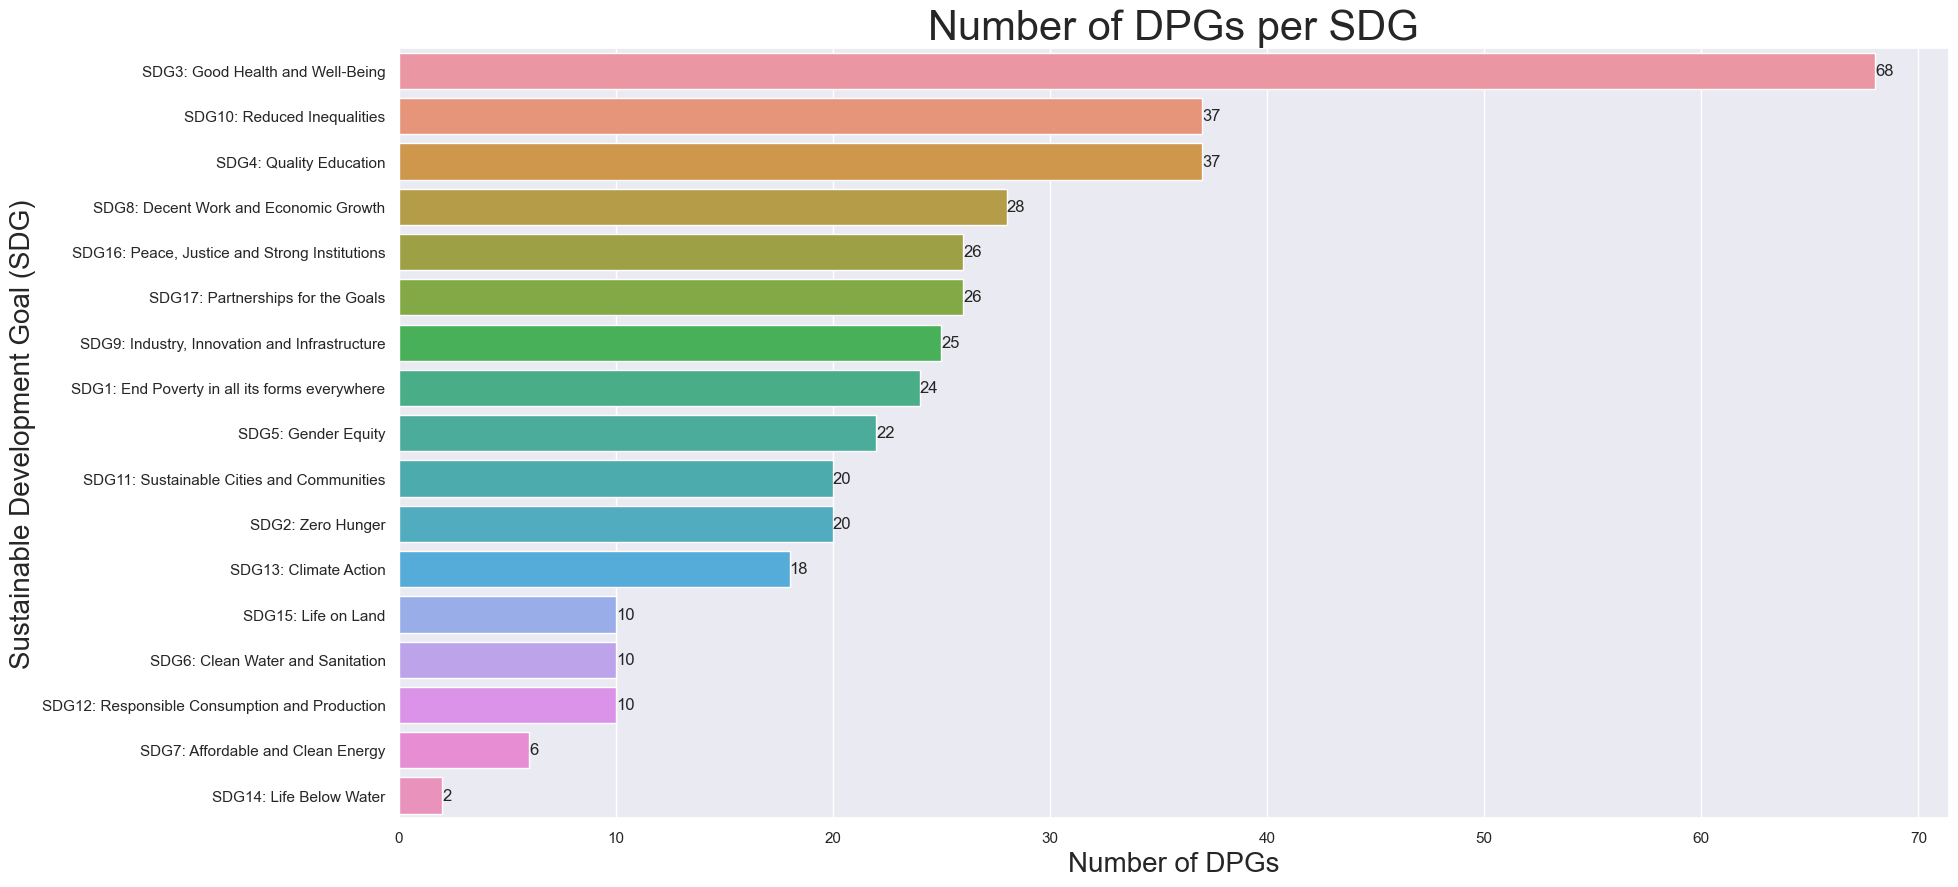

In [ ]:
sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=
ax = sns.barplot(y="sdg", x="numberOfDPGs", data=sdgs_count_df )
_ = ax.bar_label(ax.containers[0])

plt.title("Number of DPGs per SDG", size=30)
plt.xlabel("Number of DPGs", size=20)
plt.ylabel("Sustainable Development Goal (SDG)", size=20)


# What categories of DPGs are being developed?
Software, AI/ML models, content, standards?

In [ ]:
categories_count_df = categories_df.groupby('categories').size().sort_values(ascending=False).reset_index(name="numberOfDPGs")
print("categories count len: ", len(categories_df))
categories_count_df



categories count len:  146


,categories,numberOfDPGs
0,Open Software,117
1,Open Content,13
2,Open Data,12
3,Open AI Model,3
4,,1


Text(0, 0.5, 'Type of DPG')

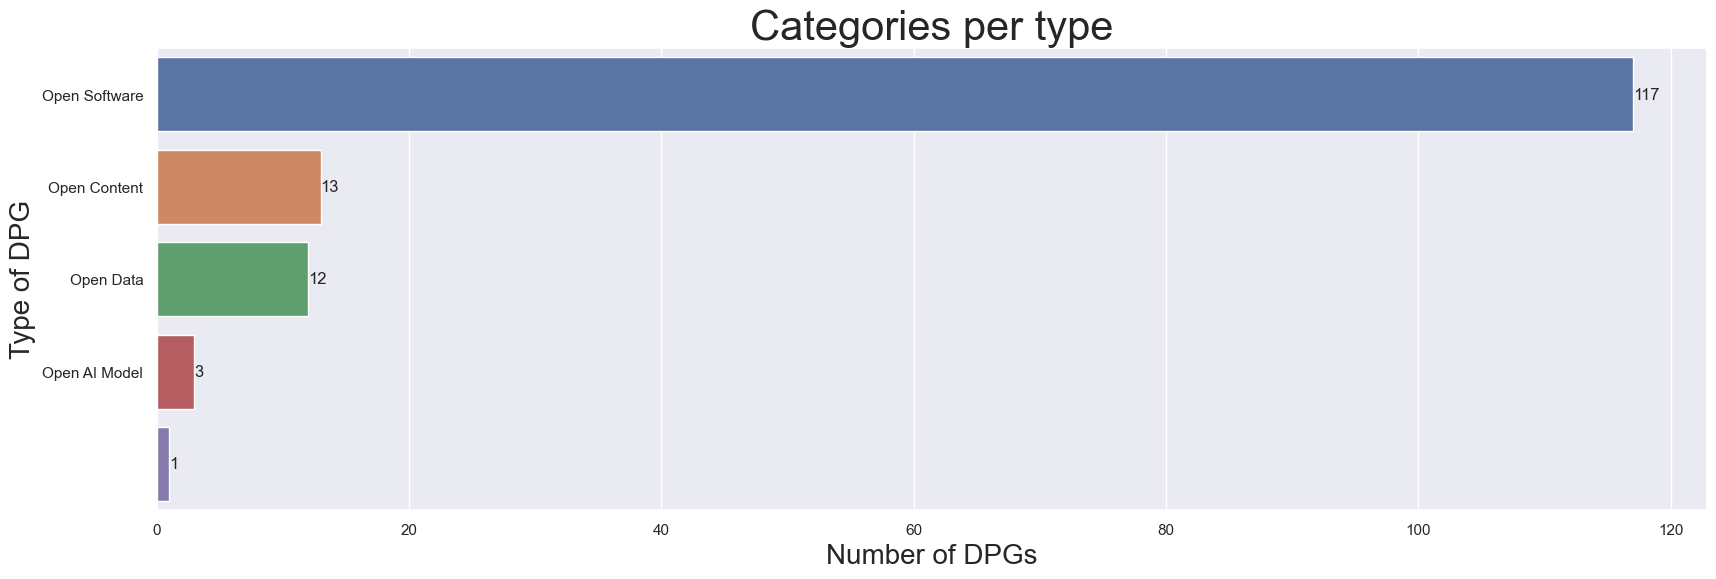

In [ ]:
sns.set(rc={"figure.figsize":(20, 6)}) #width=3, #height=
ax = sns.barplot(y="categories", x="numberOfDPGs", data=categories_count_df )
_ = ax.bar_label(ax.containers[0])

plt.title("Categories per type", size=30)
plt.xlabel("Number of DPGs", size=20)
plt.ylabel("Type of DPG", size=20)




Text(0.5, 0, '% of DPGs')

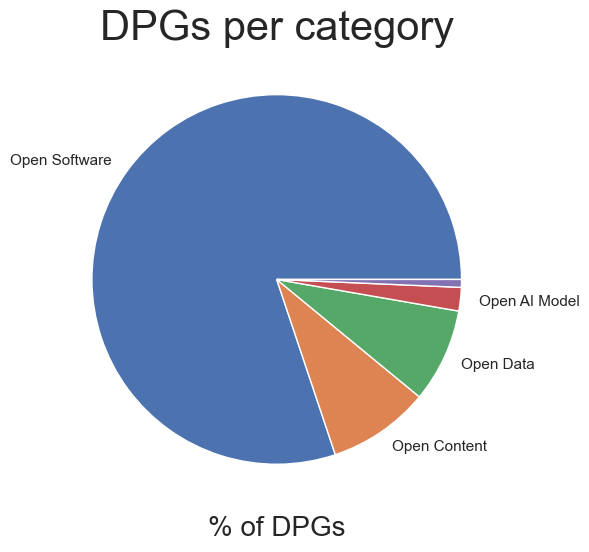

In [ ]:
sns.set(rc={"figure.figsize":(20, 6)}) #width=3, #height=
plt.pie(categories_count_df.numberOfDPGs, labels=categories_count_df.categories )
plt.title("DPGs per category", size=30)
plt.xlabel("% of DPGs", size=20)




# What about PII collection in the DPGs?  

                                         collectsPII  numberOfDPGs
0  PII data is collected and stored but NOT distr...            65
1  PII data is NOT collected NOT stored and NOT d...            51
2  PII data is collected and stored and distributed.            24
3  PII data is collected but NOT stored and NOT d...             2


Text(0.5, 0, '% of DPGs')

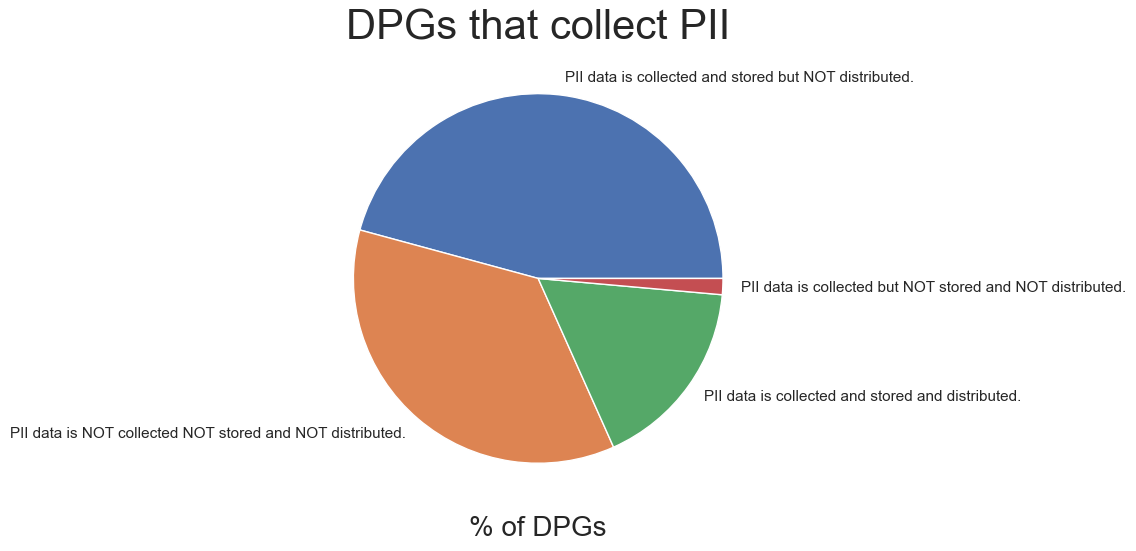

In [ ]:
collects_pii_df = df.groupby('collectsPII').size().sort_values(ascending=False).reset_index(name='numberOfDPGs')
print(collects_pii_df)

sns.set(rc={"figure.figsize":(20, 6)}) #width=3, #height=
plt.pie(collects_pii_df.numberOfDPGs, labels=collects_pii_df['collectsPII'] )
plt.title("DPGs that collect PII", size=30)
plt.xlabel("% of DPGs", size=20)

-----

# Exercise set 2 - A more advanced analysis

We have analyzed some of the fields of the DPG API response, probably the easiest. There are other fields from which we can extract insights. 

1. We have shown some graphs, but we haven't draw any insights. What conclusions and insights can you derive from the graphs we have displayed? 
2. We added a `timestamp` column. Can you think how can you use it if you collect data during a period of time? What kind of insights would you be able to draw?
3. What about the other fields (which are less structured)? Can you think about what kind of analysis can be done?
4. Now, based on the DPGA and the [SGD indicators](https://unstats.un.org/sdgs/dataportal): 
       * Can we infer if Digital Public Good technology is making any kind of dent on advancing on the SGDs Goals? 
       * Are the countries that are using DPGs more advanced in achieving the goals?


### [Share your answers Online - Join the dicussion](https://github.com/unicef/magasin/discussions/12)

-----

# Next steps

With this notebook we have extracted some graphs that can provide insights from the data provided by the DPGA. Notebooks offer a very interactive interface for running experiments to analyze data. In this case we just used a public API, but this can be done also with the internal and public data of your organization and/or your team.

Whereas the notebooks provide interactivity, you are forced to run them manually so if you want to perform this analysis in an automated way, you can't. In order to do that, **we will use another component of [magasin](https://github.com/unicef/magasin/): Dagster**. 



